# Bone marrow lymphoid B and pDCs acute (4h) response to LPS-SI
Author: Farid Keramati  
Date: 02/10/2022

Use the following code to characterize the acute (4h) response of bone marrow-resident lymphoid B lineage and pDCs to LPS-induced systemic inflammation.  
To run the following code, we will use the Seurat object generated in the [first analysis script](https://github.com/fkeramati/LPS-SI/blob/main/Analysis%20Scripts/All%20Bone%20Marrow%20Mononuclear%20Cell%20from%20All%20Time%20Points.ipynb).<br></br>
First, we will subset day 0 and 4 hours samples and then will subset lymphoid T and NK cells.

### Load required packages

In [1]:
suppressMessages(library(ggplot2))
suppressMessages(library(Seurat))
suppressMessages(library(SeuratWrappers))

### Read in previously generated Seurat object and subset B lineage cells and pDCs

In [2]:
bm = readRDS("./Bonemarrow_allCells_allTimePoints_MNN_batchCorrected.rds")
bm = subset(bm, subset = TimePoint == "D7", invert = T)
lympho_tmp = subset(bm, idents = c("Pro B", "B", "Plasma", "pDC"))

counts = GetAssayData(lympho_tmp, slot = "counts")
lymphB = CreateSeuratObject(counts = counts, project = "Lympho_B", min.cells = 0, min.features = 0)
rm(lympho_tmp, counts)

### Normalize, scale and perform dimentionality reduction
After each round of visualization, I will remove few contaminating cells (from other lineages), to get to a pure population of B + pDC cells.

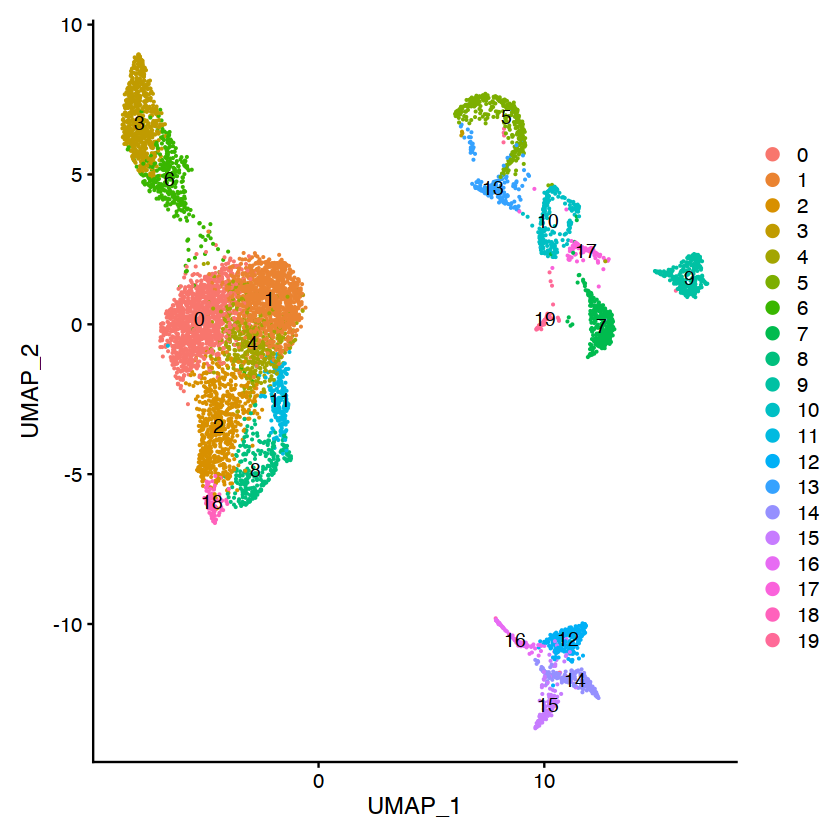

In [3]:
# Normalize and Scale
lymphB = NormalizeData(lymphB, normalization.method = "LogNormalize", scale.factor = 10000, verbose = F)
lymphB = FindVariableFeatures(lymphB, selection.method = "vst", nfeatures = 3000, verbose = F)
s.genes = cc.genes.updated.2019$s.genes
g2m.genes = cc.genes.updated.2019$g2m.genes
lymphB = CellCycleScoring(lymphB, s.features = s.genes, g2m.features = g2m.genes, set.ident = T)
lymphB$CC.Difference = lymphB$S.Score - lymphB$G2M.Score
lymphB = ScaleData(lymphB, features = rownames(lymphB), verbose = F)

# PCA, UMAP visualization and clustering
lymphB = RunPCA(lymphB, verbose = F)
lymphB = RunUMAP(lymphB, dims = 1:16, verbose = F)
lymphB = FindNeighbors(lymphB, dims = 1:16, k.param = 20, verbose = F)
lymphB = FindClusters(lymphB, resolution = 1.2, verbose = F)
lymphB@meta.data$Donor = unlist(strsplit(names(lymphB$orig.ident), split = "_"))[c(T,F,F)]
lymphB@meta.data$TimePoint = unlist(strsplit(names(lymphB$orig.ident), split = "_"))[c(F,T,F)]
DimPlot(lymphB, label = T, pt.size = 0.1)

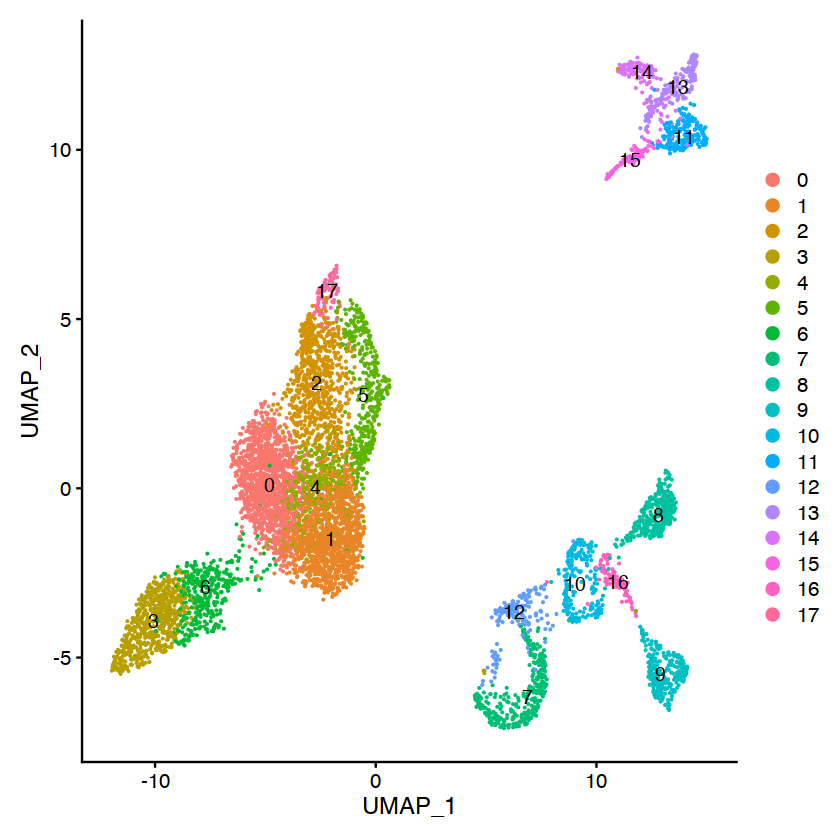

In [4]:
# Remove cluster 19 and RunUMAP again (doubltes of B and T cells)
lymphB = subset(lymphB, idents = 19, invert = T)

# Normalize and Scale
lymphB = NormalizeData(lymphB, normalization.method = "LogNormalize", scale.factor = 10000, verbose = F)
lymphB = FindVariableFeatures(lymphB, selection.method = "vst", nfeatures = 3000, verbose = F)
lymphB = ScaleData(lymphB, features = rownames(lymphB), verbose = F)

# PCA, UMAP visualization and clustering
lymphB = RunPCA(lymphB, verbose = F)
lymphB = RunUMAP(lymphB, dims = 1:15, min.dist = 0.4, spread = 0.9, verbose = F)
lymphB = FindNeighbors(lymphB, dims = 1:16, k.param = 20, verbose = F)
lymphB = FindClusters(lymphB, resolution = 1.2, verbose = F)
DimPlot(lymphB, label = T, pt.size = 0.1)

### Batch correct using MNN and visualize cells

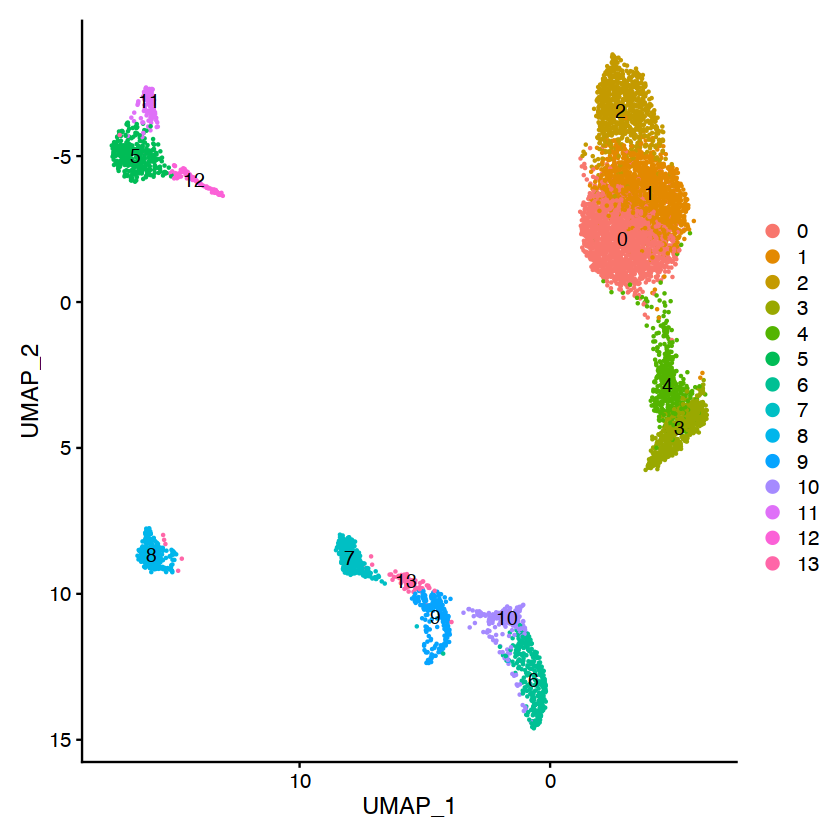

In [5]:
# There is a donor batch effect, correct for it using MNN
lymphB_mnn = RunFastMNN(object.list = SplitObject(lymphB, split.by = "Donor"), features = 2000, verbose = F)
lymphB_mnn = RunUMAP(lymphB_mnn, dims = 1:20, reduction = "mnn", min.dist = 0.3, verbose = F)
lymphB_mnn = FindNeighbors(lymphB_mnn, dims = 1:20, reduction = "mnn", k.param = 20, verbose = F)
lymphB_mnn = FindClusters(lymphB_mnn, resolution = 1.5, verbose = F)
DimPlot(lymphB_mnn, label = T) + scale_y_reverse() + scale_x_reverse()

### Refine cell clustering and assign cell types to each cluster
Cell type assignment is based on known canonical markers.

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 875
Number of edges: 31918

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.5869
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 262
Number of edges: 11817

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.4336
Number of communities: 4
Elapsed time: 0 seconds


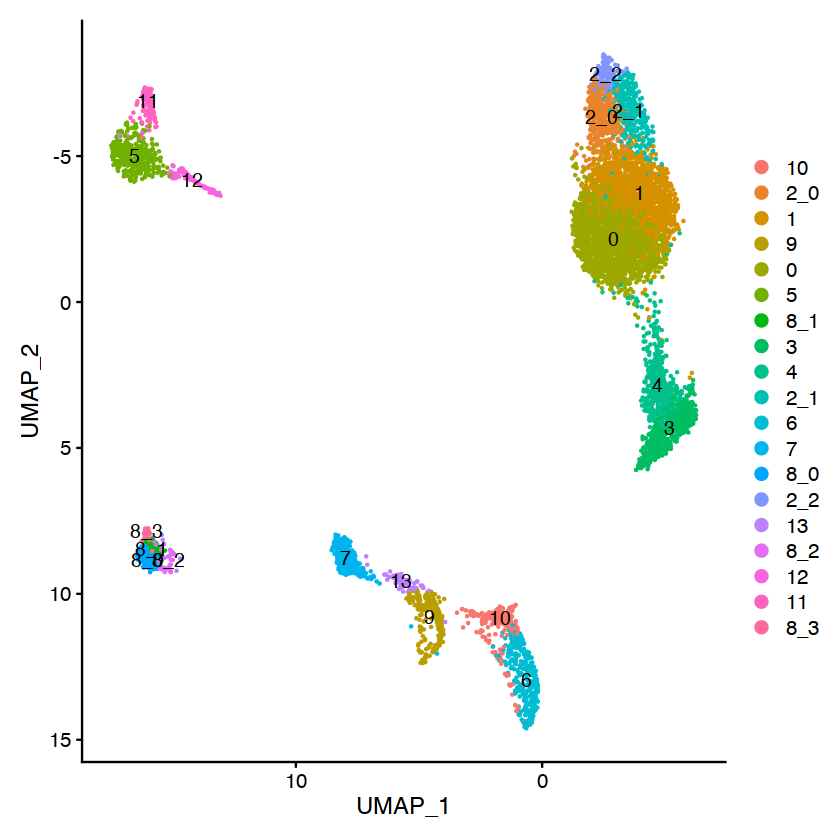

In [6]:
# I need to sub-cluster cluster 2 again
lymphB_mnn = FindSubCluster(lymphB_mnn, cluster = 2, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.5, algorithm = 1)
Idents(lymphB_mnn) = lymphB_mnn$sub.cluster

# I need to sub-cluster cluster 8 again
lymphB_mnn = FindSubCluster(lymphB_mnn, cluster = 8, graph.name = "RNA_snn", subcluster.name = "sub.cluster", resolution = 0.7, algorithm = 1)
Idents(lymphB_mnn) = lymphB_mnn$sub.cluster

DimPlot(lymphB_mnn, label = T) + scale_y_reverse() + scale_x_reverse()

In [7]:
# Name clusters
lymphB_mnn = RenameIdents(lymphB_mnn, "0" = "Naive B", 
                          "1" = "Naive B", 
                          "2_0" = "Memory B", 
                          "2_1" = "Inflam Mem B", 
                          "2_2" = "Memory B",
                          "3" = "Pre-B I", 
                          "4" = "Pre-B II", 
                          "5" = "Plasma", 
                          "6" = "Cycling Pre-B", 
                          "7" = "Pro B", 
                          "8_0" = "Inflam pDC",
                          "8_1" = "pDC", 
                          "8_2" = "pDC", 
                          "8_3" = "pDC", 
                          "9" = "Cycling Pro-B", 
                          "10" = "Cycling Pre-B", 
                          "11" = "Plasma",
                          "12" = "Plasma", 
                          "13" = "CLP")
lymphB@active.ident = factor(lymphB@active.ident, levels = c("CLP", "Cycling Pro-B", "Pro B", "Cycling Pre-B", "Pre-B I", "Pre-B II",
                                                     "Naive B", "Memory B", "Inflam Mem B", "Plasma", "Inflam Plasma",
                                                     "pDC", "Inflam pDC"))
lymphB_mnn$CellType = lymphB_mnn@active.ident

### Visualize cells (colored by cell type)

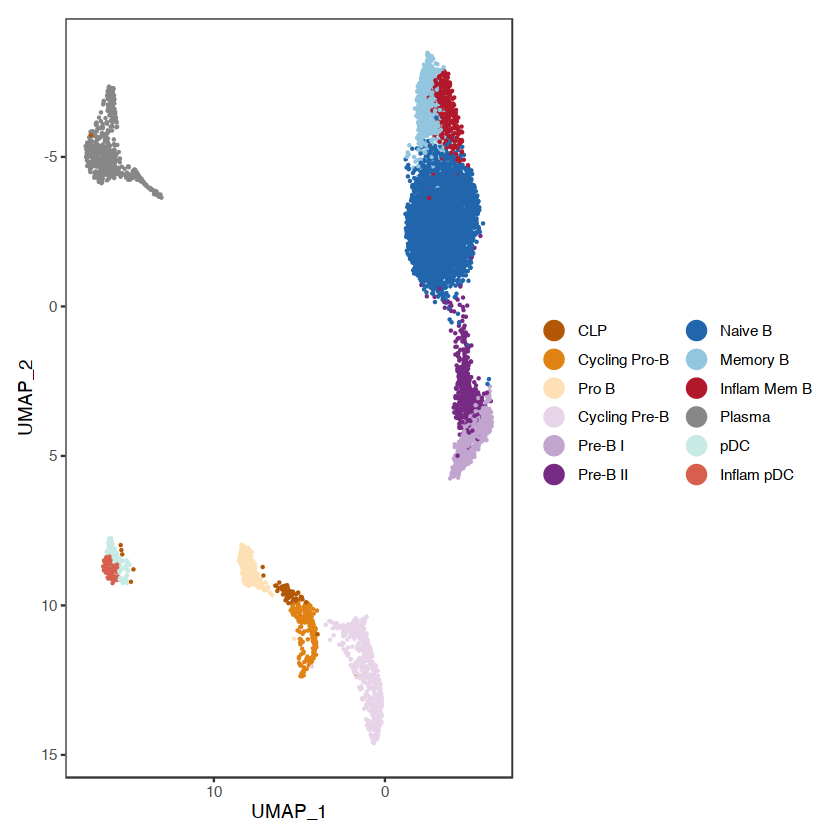

In [8]:
DimPlot(lymphB_mnn, pt.size=0.2) + theme_bw() + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) +
  scale_color_manual(values=c("CLP"="#b35806", 
                              "Cycling Pro-B"="#e08214", 
                              "Pro B"="#fee0b6", 
                              "Cycling Pre-B"="#e7d4e8", 
                              "Pre-B I"="#c2a5cf", 
                              "Pre-B II"="#762a83", 
                              "Naive B"="#2166ac", 
                              "Memory B"="#92c5de", 
                              "Inflam Mem B"="#b2182b", 
                              "Plasma"="#878787", 
                              "pDC"="#c7eae5", 
                              "Inflam pDC"="#d6604d")) +
  guides(color=guide_legend(ncol=2, override.aes = list(size=5))) + scale_y_reverse() + scale_x_reverse()

### Visualize cells (colored by time point)

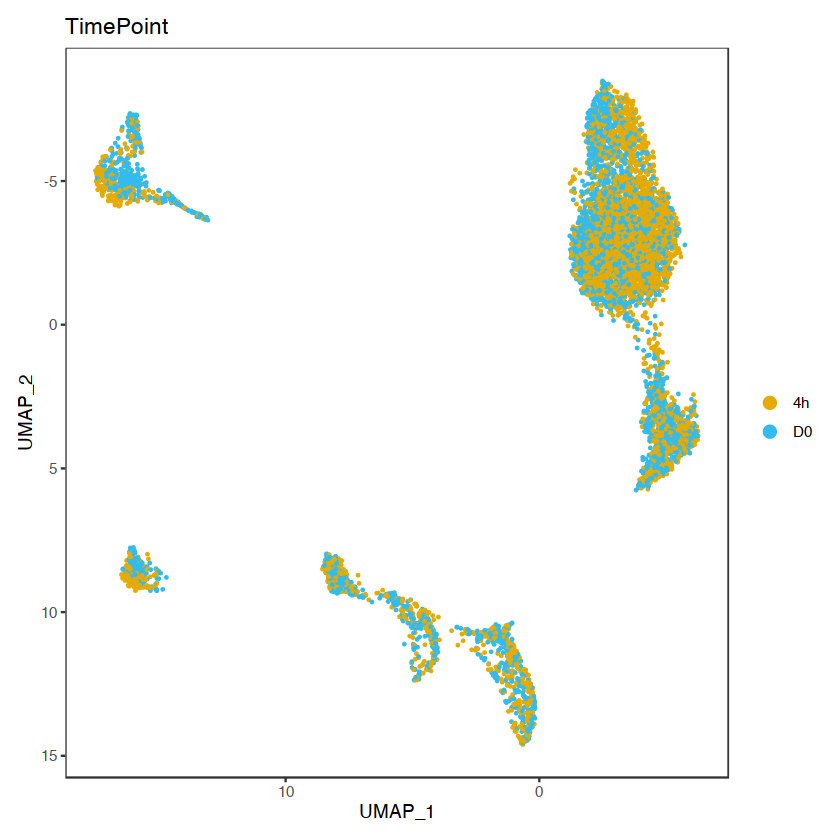

In [9]:
DimPlot(lymphB_mnn, label = F, pt.size = 0.3, group.by = "TimePoint", shuffle = T) + scale_color_manual(values=c("#e6ab02", "#33bbee", "#ee3377")) +
  theme_bw() + theme(panel.grid.major=element_blank(), panel.grid.minor=element_blank()) + scale_y_reverse() + scale_x_reverse()

### Save object

In [10]:
saveRDS(lymphB_mnn, "LymphoidB_pDC_Day0_4h_MNN_batchCorrected.rds")